In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False



# 차원 축소


많은 경우 머신러닝 문제는 훈련 샘플 각각이 수천 심지어 수백만 개의 특성을 가지고 있다. 이는 훈련을 느리게 할 뿐만 아니라, 앞으로 보게 되겠지만 좋은 솔루션을 찾기 어렵게 만든다. 이를 종종 **차원의 저주**라고 부른다

차원을 축소 시키면 일부 정보가 유실된다. 그래서 훈련속도가 빨라질 순 있지만 성능이 나빠지고 작업 파이프 라인이 복잡하고 유지관리가 어려워질 수 있다. 그러나 어떤 경우는 훈련데이터의 잡음이나 불필요한 세부사항을 걸러내므로 성능을 높일 수 있다.

## 8.1 차원의 저주

고차원 공간에서는 많은 것이 상당히 다르게 작동한다. 대부분의 훈련 데이터가 서로 멀리 떨어져있다. 물론 이는 새로운 샘플도 훈련 샘플과 멀리 떨어져 있을 가능성이 높다는 뜻이다. 이 경우 예측을 위해 훨씬 많은 외삽을 해야 하기 때문에 저차원일 때보다 예측이 더 불안정하다. 간단히 말해 훈련 세트의 차원이 클수록 과대적합 위험이 커진다.

## 8.2 차원 축소를 위한 접근 방법

### 8.2.1 투영 (projection)

대부분의 실전문제는 훈련 샘플이 모든 차원에 걸쳐 균일하게 퍼져 있지 않다. 많은 특성은 거의 변화가 없는 반면, 다른 특성들은 서로 강하게 연관되어있다. 결과적으로 모든 훈련 샘플이 사실 고차원 공간 안의 저차원 **부분 공간**에 놓여 있다.

In [6]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [8]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [9]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])
X3D_inv = pca.inverse_transform(X2D)

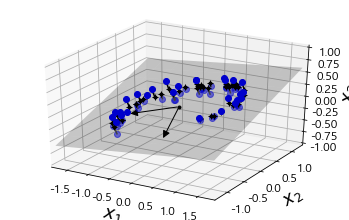

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=4)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

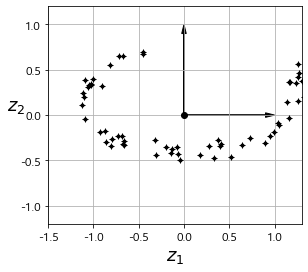

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)


투영해서 2D 데이터셋을 얻었다. 하지만 언제나 최선의 방법은 아니다. **스위스 롤**처럼 부분공간이 뒤틀리거나 휘어 있기도 하다.

In [12]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

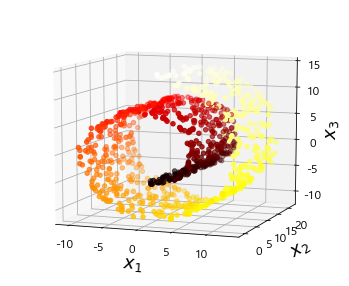

In [13]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

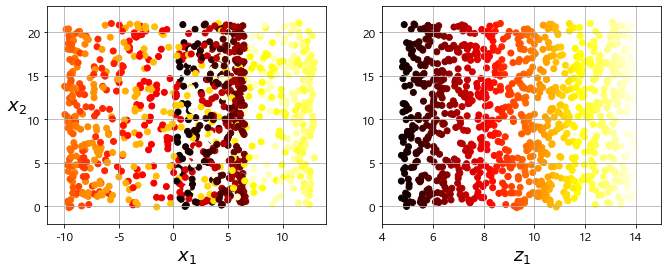

In [14]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0, labelpad=10)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)


plt.show()

### 8.2.2 매니폴드 학습

스위스롤은 2D **매니폴드**의 한 예이다. 많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링 하는 식으로 작동한다. 이를 매니폴드 학습이라고 한다. 이는 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정에 근거한다.   

모델을 훈련시키기 전에 훈련세트의 차원을 감소시키면 훈련속도는 빨라지지만 항상 더 낫거나 간단한 솔루션이 되는 것은 아니다. 이는 전적으로 데이터셋에 달렸다.

## 8.3 PCA

**주성분 분석**은 가장 인기 있는 차원 축소 알고리즘이다. 먼저 데이터에 가장 가까운 초평면을 정의한 다음, 데이터를 이 평면에 투영시킨다.

### 8.3.1 분산 보존

![pca](./images/pca.png)
다른 방향으로 투영하는 것보다 분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적으로 보인다. 이 선택을 다른 방식으로 설명하면 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화 하는 축이다.

### 8.3.2 주성분

- 첫번째 축에 직교하고 남은 분산을 최대한 보존하는 두번째 축을 찾는다.    


- 고차원 데이터셋이라면 pca는 이전의 두 축에 직교하는 세 번째 축을 찾으며 데이터셋에 있는 차원의 수 만큼 네 번째, 다섯번째, 축을 찾는다.   


- i번째 축을 정의하는 단위 벡터를 i번째 **주성분(pc)**라고 한다

훈련세트의 주성분을 어떻게 찾을까?  

특잇값 분해(SVD)로 훈련세트 X를 $ U*\Sigma*V^T$로 분해할 수 있다.

In [15]:
from __future__ import division, print_function, unicode_literals

In [16]:
import numpy as np
import os

In [17]:
np.random.seed(42)

In [18]:
np.random.seed(4)
m=60
w1,w2=0.1,0.3
noise=0.1

angles=np.random.rand(m)*3*np.pi/2-0.5
X=np.empty((m,3))
X[:,0]=np.cos(angles)+np.sin(angles)/2+noise*np.random.randn(m)/2
X[:,1]=np.sin(angles)*0.7+noise*np.random.randn(m)/2
X[:,2]=X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [19]:
X_centered=X-X.mean(axis=0)
U,s,Vt=np.linalg.svd(X_centered)
c1=Vt.T[:,0]
c2=Vt.T[:,1]

PCA는 데이터셋의 평균이 0이라고 가정한다. 앞으로 볼 사이킷런의 PCA 클래스는 이 작업을 대신 처리해준다. 그러나 직접 구현하거나 다른 라이브러리를 사용하는 경우는 먼저 데이터를 원점에 맞추는 것을 잊어서는 안된다.

### 8.3.3 d차원으로 투영하기

주성분을 모두 추출해냈다면 처음 d개의 주성분으로 정의한 초평면에 투영하여 데이터셋의 차원을 d차원으로 축소시킬 수 있다.   

초평면에 훈련세트를 투영하기 위해서는 

$$X_{d-proj} = X * W_d$$

In [20]:
# 첫 두 개의 주성분으로 정의된 평면에 훈련세트를 투영한다.
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

### 8.3.4 사이킷런 사용하기

사이킷런의 PCA 모델은 앞서 한 것 처럼 SVD 분해 방법을 사용하여 구현한다. 

In [21]:
#다음은 PCA 모델을 사용해 데이터셋의 차원을 2로 줄이는 코드이다
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
X2D=pca.fit_transform(X)

In [22]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

### 8.3.5 설명된 분산 비율

설명된 분산의 비율도 유용한 정보 중 하나이다. 이 값은 각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타낸다.

In [23]:
# 84.2%가 첫 번째 축에 놓여 있고 14.6%가 두 번째 축에 놓여 있음을 알려줌 
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

### 8.3.6 적절한 차원 수 선택하기

축소할 차원 수를 임의로 정하기 보다는 충분한 분산이 될 때까지 더해야 할 차원 수를 선택하는 쪽을 더 선호한다. 

In [24]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print('선택할 차원 수 :', d)

선택할 차원 수 : 2


In [25]:
# 유지하려는 주성분의 수를 지정하기 보단 분산 비율을 0에서 1 사이로 설정하는게 좋음
pca = PCA(n_components=0.95)
X_proj = pca.fit_transform(X)

print('principal component vec :\n', pca.components_.T)

principal component vec :
 [[-0.93636116  0.34027485]
 [-0.29854881 -0.90119108]
 [-0.18465208 -0.2684542 ]]


### 8.3.7 압축을 위한 PCA

확실히 차원을 축소하고 난 후에는 훈련 세트의 크기가 줄어든다. 분산의 95%를 유지하고 크기를 원본의 20% 미만으로 압축하게 되면 상당한 압축률이고 (SVM 같은) 분류 알고리즘의 속도를 크게 높일 수 있다.  

또한 압축된 데이터셋에 PCA 투영 변환을 반대로 적용하여 784개의 차원으로 되돌릴 수도 있다. 물론 투영에서 일정량의 정보(유실된 5%의 분산)를 잃어버렸기 때문에 이렇게 해도 원본 데이터셋을 얻을 수는 없다.  

원본 데이터와 재구성된 데이터 사이의 평균 제곱 거리를 **재구성 오차**라고 한다. 

In [26]:
# MNISt 데이터셋을 154차원으로 압축하고 inverse_transform() 메서드를 사용해 784차원으로 복원
from keras.datasets import mnist

# MNIST load
(train_x, train_y), (test_x, test_y) = mnist.load_data()

# reshape
train_x = train_x.reshape(-1, 28*28) 

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(train_x)

Using TensorFlow backend.
C:\Users\chlgy\Anaconda3\envs\tf0\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\chlgy\Anaconda3\envs\tf0\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\chlgy\Anaconda3\envs\tf0\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\chlgy\Anaconda3\envs\tf0\lib\site-packages\t

In [27]:
print('선택한 차원(픽셀) 수 :', pca.n_components_)

선택한 차원(픽셀) 수 : 154


In [28]:
X_recovered = pca.inverse_transform(X_reduced)

In [29]:

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

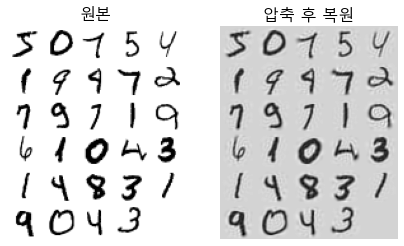

In [30]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(train_x[::2100])
plt.title("원본", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("압축 후 복원", fontsize=16)
plot_digits(X_recovered[::2100])

역변환 공식은 다음과 같다.  


$$ X_{recovered} = X_{d-proj} * W_{d}^T $$

### 8.3.8 점진적 PCA

PCA 구현의 문제는 SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 한다는 것이다. 다행히 **점진적 PCA (IPCA)** 알고리즘이 개발되었다. 훈련세트를 미니배치로 나눈뒤 IPCA 알고리즘에 한 번에 하나씩 주입한다. 이런 방식은 훈련세트가 클 때 유용하고 온라인으로 PCA를 적용 할 수도 있다.

In [31]:
#다음 코드는 MNIST 데이터셋을 100개의 미니배치로 나누고 사이킷런의 INcrementalPCA 파이썬 클래스를 주입해 차원으로 154개로 줄인다.

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for batch_x in np.array_split(train_x, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(batch_x)

X_reduced = inc_pca.transform(train_x)

....................................................................................................

또 다른 방법은 넘파이의 memmap 파이썬 클래스를 사용해 하드 디스크의 이진 파일에 저장된 매우 큰 배열을 메모리에 들어 있는 것처럼 다루는 것. 이 파이썬 클래스는 필요할 때 데이터를 메모리에 적재한다. IncrementalPCA는 특성 순간에 배열의 일부만 사용하기 때문에 메모리 부족 문제를 해결할 수 있다.

In [22]:

X_mm=np.memmap(filename, dtype="float32", mode="readonly", shape=(m,n))

batch_size=m//n_batches
inc_pca=IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)


IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [32]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

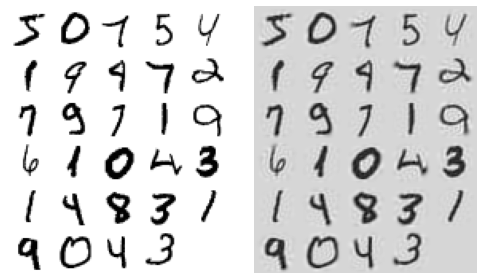

In [33]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(train_x[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

### 8.3.9 랜덤 PCA

사이킷런에는 PCA의 또 다른 옵션으로 **랜덤 PCA**를 제공한다. 이 방식은 확률적인 알고리즘으로, 첫 d개의 주성분에 대한 근삿값을 빠르게 찾는다.

In [34]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(train_x)

In [35]:
X_reduced.shape

(60000, 154)

## 8.4 커널 PCA

5장에서 샘플을 매우 높은 고차원 공간(**특성 공간**)으로 암묵적으로 매핑하여 서포트 벡터 머신의 비선형 분류와 회귀를 가능하게 하는 수학적 기법인 커널 트릭에 대해 이야기 했다. 고차원 특성 공간에서의 선형 결정 경계는 원본 공간에서는 복잡한 비선형 결정경계에 해당한다.  

같은 기법을 PCA에 적용해 복잡한 비선형 투영으로의 차원축소를 가능하게 할 수 있다. 이를 **커널 PCA (kPCA)** 라고 한다. 이 기법은 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠때도 유용하다

In [36]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [37]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

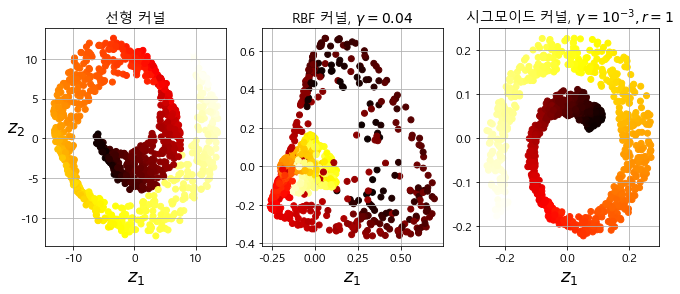

In [38]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "선형 커널"), (132, rbf_pca, "RBF 커널, $\gamma=0.04$"), (133, sig_pca, "시그모이드 커널, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### 8.4.1 커널 선택과 하이퍼파라미터 튜닝

kPCA는 비지도 학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없다. 하지만 차원 축소는 종종 지도학습의 전처리 단계로 활용되므로 그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택할 수 있다.  

다음 코드는 먼저 kPCA를 사용해 차원을 2차원으로 축소하고 분류를 위해 로지스틱 회귀를 적용한다. 그런 다음 파이프라인 마지막 단계에서 가장 높은 분류 정확도를 위해 GridSearchCV를 사용해 kPCA의 가장 좋은 커널과 gamma 파라미터를 찾는다.

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [40]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


완전한 비지도 학습으로 가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터를 선택하는 방식도 있다. 하지만 재구성은 선형 PCA 만큼 쉽지 않다.  

**재구성 원상**은 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트를 찾는것이다. 원상을 얻게 되면 원본 샘플과의 제곱 거리를 측정할 수 있고 재구성 원상의 오차를 최소화 하는 커널과 하이퍼파라미터를 선택할 수 있다.


In [41]:
# fit_inverse_transform=True 로 지정하면 재구성을 자동으로 수행한다.

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [42]:
# 재구성 원상 오차 계산

from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.7863087957661

## 8.5 LLE

**지역 선형 임베딩 (LLE)** 은 또 다른 강력한 **비선형 차원 축소 (NLDR)** 기술이다. 이전 알고리즘처럼 투영에 의존하지 않는 매니폴드 학습이다. 간단히 말해 LLE는 먼저 각 훈련 샘플이 가장 가까운 이웃에 얼마나 선형적으로 연관되어 있는지 측정한다. 그런 다음 국부적인 관계가 가장 잘 보존되는 훈련세트의 저차원 표현을 찾는다.  

In [45]:
# 사이킷런의 LocallyLinearEmbedding을 사용해 스위스롤을 펼친다.

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

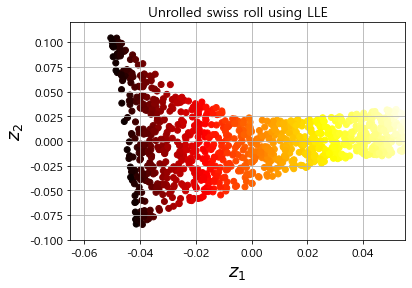

In [46]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

오른쪽은 잘 압축되어 있고 확장되어 있고 크게 보면 샘플간 거리가 잘 유지되어 있지 않다. 그럼에도 불구하고 LLE는 매니폴드를 모델링 하는데 잘 작동한다